### Introduction

I've been looking for a Data Analysis job recently and failed to do so. Actually I got several offers for Python Developer position but the work in these companies are quite boring so I left. The fact is Data Science / Data Mining / Machine Learning jobs in the north of Vietnam are quite rare. There are a lot more jobs in this field in Ho Chi Minh city.

With my free time I decided to do some analysis about job market for the last few months in Vietnam. This is written with the main purpose to consolidate my knowledge about exploratory data analysis, so I will not take it very seriously about data source. I wrote some scripts to crawl job data from only one website Vietnamworks.com for the last few months. I tried to get data for the first 5 months of 2016, but it seems Vietnamworks doesn't show their past data after a specific period. The best I could get is from April. Not much, but this is for fun anyway.

[In my last post](http://hoanvu.github.io/2016/05/scraping-jobs-from-vietnamworks), I showed you how to crawl job data from Vietnamworks using BeautifulSoup. Scripts used in that post will be reused here, but the scope is a little bit wider (from 26 URLs and several other features).

This post will focus on scaping data for IT jobs, but you can change the base URL to work with any other kind of job you want. Just go to Vietnamworks, use the website's filter to select the job categories you want to play with, and get the base URL and assign it to the `base_url` variable in `get_all_urls()` method.

### Package requirements:

If you do not have those packages installed on your system, please do so before continue:

- beautifulsoup4
- matplotlib
- seaborn
- pandas 

In [1]:
# Imports & Settings

# Make sure packages in my virtual environment are included
import sys
sys.path.append('/home/hoanvu/anaconda2/envs/ds/lib/python2.7/site-packages/')

import requests
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from bs4 import BeautifulSoup
from collections import Counter, defaultdict
from datetime import datetime

%pylab inline
sns.set_context('poster')

# No of URLs to crawl from Vietnamworks
MAX_PAGE = 27

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


Next, we will write a method to get all URLs for the job categories of your choice. 
- base_url: this is the URL of the first page after you configure your filter on Vietnamworks website and press 'Search'
- extended_url_pages: we want to crawl more than just the first page. `base_url` is the first page, all subsequence pages will have the extension in the URL, with `page-2` for the second page, `page-3` for the third page and so on

  We we get advantage of this uniform to construct our list of URLs

In [2]:
def get_all_urls():
    """
    Scan through all URLs defined by MAX_PAGE and return the URL
    
    return: list of URLs
    """
    
    base_url = 'http://www.vietnamworks.com/it-hardware-networking-it-software-jobs-i55,35-en'
    extended_url_pages = ['/page-{}'.format(page_number) for page_number in xrange(2, MAX_PAGE)]
    urls = [base_url + extended_page for extended_page in extended_url_pages]
    urls.insert(0, base_url)
    return urls

### Data collection

Features that need to be collect:

- Job title
- Technical skills
- Work location
- Position
- Company name
- Job post date
- Job salary

This method get_jobs_in_url() get details for all job in a single URL. You can see my [previous post](http://127.0.0.1:4000/2016/05/vietnam-it-jobs-analysis) for explanation about the code.

In [3]:
def get_jobs_in_url(url):
    """
    Take a single URL and return a pandas DataFrame contains details about all jobs in that URL.
    
    return: pandas.DataFrame
    """
    req = requests.get(url)
    soup = BeautifulSoup(req.content, 'html.parser')
    
    jobs_table = soup.find('table', {'class': 'link-list'})
    tr_tags = jobs_table.find_all('tr', {'class': 'job-post'})
    
    job_title = []
    job_company = []
    job_location = []
    job_position = []
    job_skills = []
    job_date = []
    
    for job in tr_tags:
        job_title.append(job.find('a', {'class': 'job-title'}).contents[0])
        job_company.append(job.find('span', 'name').contents[0])
        job_location.append(job.find('p', {'class': 'job-info'}).contents[1].find('span').contents[0])
        job_position.append(job.find('p', {'class': 'job-info'}).contents[1].find_all('span')[1].contents[0])
                            
        skill_list_data = job.find('div', {'class': 'skills'})
        if skill_list_data:
            skill_list = skill_list_data.find_all('em', {'class': 'text-clip'})
            
        job_skills.append([skill.contents[0] for skill in skill_list])
        
        # Job post date
        d = job.find('span', {'class': 'views'}).find('span').contents[0].split(' ')[1]
        if d == 'Today':
            d = datetime.datetime.now().strftime("%d/%m/%Y")
        job_date.append(d)
    
        # Job salary
        
    return pd.DataFrame({
            'job_title': job_title,
            'company': job_company,
            'location': job_location,
            'position': job_position,
            'skills': job_skills,
            'post_date': job_date
        })

This method `get_all_jobs()` just scan through all URLs from `get_all_urls()` and get details for all jobs listed in each and every page:

In [4]:
def get_all_jobs():
    """
    Scans all URLs and crawls all jobs from all pages
    
    return: pandas.DataFrame contains every possible job that we can find
    """
    urls = get_all_urls()
    data = pd.DataFrame()
    for url in urls:
        data = data.append(get_jobs_in_url(url), ignore_index=True)
        
    return data

jobs = get_all_jobs()

In [5]:
# Convert the job post date to datetime type
jobs['post_date'] = pd.to_datetime(jobs.post_date, format="%d/%m/%Y")

#### Let's take a quick look at our data:

In [6]:
jobs.head()

,company,job_title,location,position,post_date,skills
0,"Naviworld Vietnam Co., Ltd.",Nhân Viên Phát Triển Ứng Dụng ERP,"Ha Noi, Ho Chi Minh",Experienced (non-manager),2016-05-31,"[ERP Technical Consultant, SQL, Microsoft .NET]"
1,New Wave Solutions,Web Developer (!!!attractive Salary!!!),Ha Noi,Experienced (non-manager),2016-06-10,"[.NET C#, PHP, Java Developer - IT Software]"
2,A Japanese IT Company,[0511-HCM] [ Urgent ] Bse/project Manager ($20...,"Da Nang, Ha Noi, Ho Chi Minh",Manager,2016-06-02,"[HTML, Japanese - N2, Project Management.]"
3,"Sofiamedix Software Co.,ltd",Senior IT Business Analyst- Kỹ Sư Phân Tích Th...,Ha Noi,Experienced (non-manager),2016-06-02,"[IT Business Analyse, System Analysis & Design]"
4,"Santa Clara Ltd,.",Programmer,"Ha Nam, Ha Noi, Nam Dinh",Experienced (non-manager),2016-06-02,"[Hardware Maintenance, Visual Foxpro, SQL 2000]"


Nice, seems that our data is not very **clean**, but it says that our code until now is working. Now, let's jump to the most interesting part and see what our data says?

### Exploratory Data Analysis

At first I planned to clean this dataset a little bit more, but then I realize it would be better if I keep it this way and transform each column based on the information I need. If you read this, feel free to take the dataset and tweak it the way you want.

We will try to answer few questions as we go. 

**First, what is the general status of Vietnam job market?**

How many days did we collect the data?

In [7]:
jobs.post_date.max() - jobs.post_date.min()

Timedelta('30 days 00:00:00')

How many jobs were posted during this period?

In [8]:
"Total jobs: {}".format(len(jobs))

'Total jobs: 1131'

**1277 jobs** were posted in ** only 37 days**, I think that this is very interesting number to show that the Vietnam job market is **very bustle**. If we collect data from other sites, there maybe even much bigger number of jobs posted.

#### Which city have the most demand for job recruitment?

From the graph below, it's obvious that **Ho Chi Minh** and **Ha Noi** are two cities which have huge demand for human resources in IT, which makes sense! Ho Chi Minh is by far the most demanding city.

**Da Nang** is also a very hot city for job hunter. There are some jobs that have work location as **International**, this is very interesting!

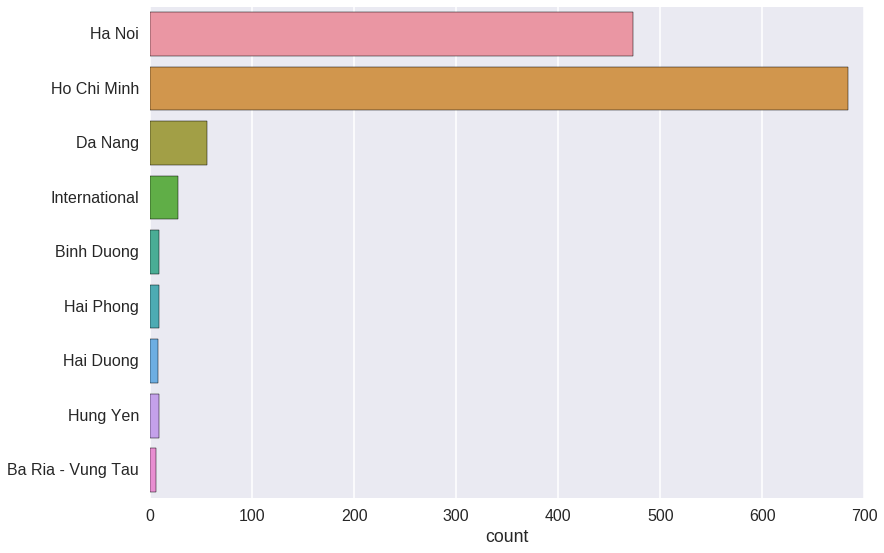

In [9]:
all_locations = []
for location in jobs.location:
    if ',' in location:
        all_locations.extend(location.split(', '))
    else:
        all_locations.append(location)

# Remove cities that have less than 5 jobs, just to make grap clearer
most_cities = [key for key, value in Counter(all_locations).iteritems() if value > 5]
new_cities = [city for city in all_locations if city in most_cities]

sns.countplot(y=new_cities)

#### What's the percentage?

In [10]:
from __future__ import division

location_counter = Counter(all_locations)
total_jobs = sum(location_counter.values())
jobs_in_hcm = location_counter['Ho Chi Minh']
jobs_in_hn = location_counter['Ha Noi']
jobs_in_dn = location_counter['Da Nang']
jobs_in_int = location_counter['International']

print "Total jobs:                     {}".format(total_jobs)
print "Jobs required by Ho Chi Minh:   {:.3f}%".format((jobs_in_hcm / total_jobs) * 100.0 )
print "Jobs required by Ha Noi:        {:.3f}%".format((jobs_in_hn / total_jobs) * 100.0 ) 
print "Jobs required by Da Nang:       {:.3f}%".format((jobs_in_dn / total_jobs) * 100.0 )
print "Jobs required by International: {:.3f}%".format((jobs_in_int / total_jobs) * 100.0) 

Total jobs:                     1320
Jobs required by Ho Chi Minh:   51.818%
Jobs required by Ha Noi:        35.833%
Jobs required by Da Nang:       4.242%
Jobs required by International: 2.045%


#### Which positions does recruiter looking for?

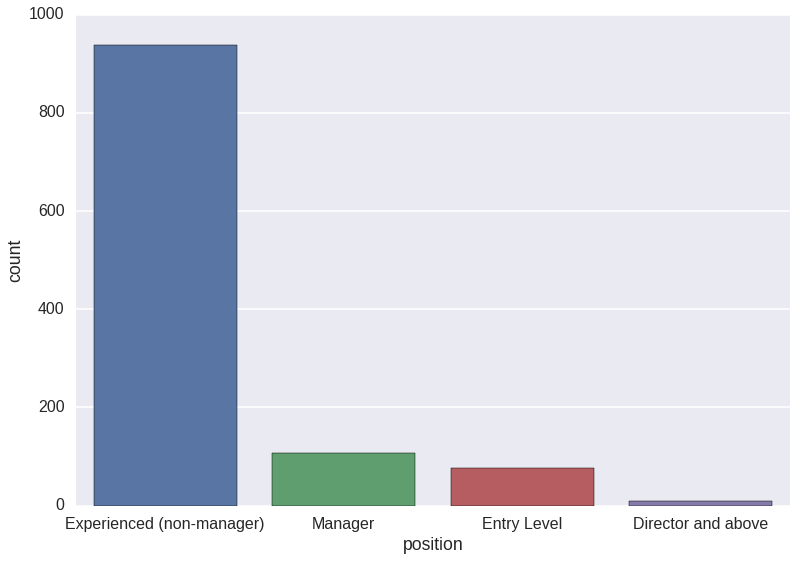

In [11]:
sns.countplot(x='position', data=jobs)

In [12]:
1055 / 1279

0.8248631743549648

It's obvious that **Specialist** position is the hottest job. 

#### Now, which skills are expected by companies?

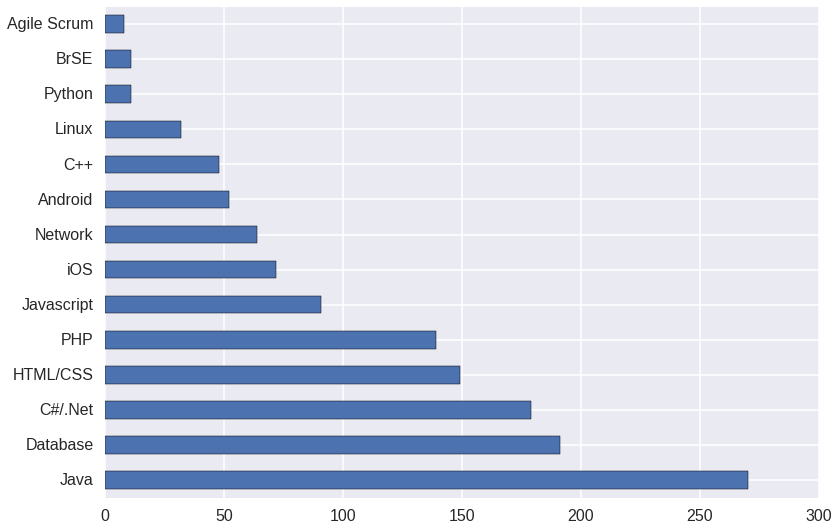

In [13]:
# Need to improve this code

skill_counter = defaultdict(int)
for row in jobs.skills:
    for skill in row:
        skill = skill.lower()
        if 'c++' in skill:
            skill_counter['C++'] += 1
        if 'java' in skill or 'j2ee' in skill or 'servlet' in skill or 'jsp' in skill or 'hibernate' in skill:
            skill_counter['Java'] += 1
        if 'ios' in skill or 'objective-c' in skill or 'objective c' in skill:
            skill_counter['iOS'] += 1
        if 'python' in skill or 'django' in skill or 'flask' in skill:
            skill_counter['Python'] += 1
        if 'html' in skill or 'css' in skill or 'css3' in skill:
            skill_counter['HTML/CSS'] += 1
        if 'android' in skill:
            skill_counter['Android'] += 1
        if 'oracle' in skill or 'sql' in skill or 'sql server' in skill or 'mysql' in skill or \
            'database' in skill or 'postgres' in skill:
            skill_counter['Database'] += 1
        if 'linux' in skill or 'redhat' in skill or 'centos' in skill or 'ubuntu' in skill:
            skill_counter['Linux'] += 1
        if 'cisco' in skill or 'ccna' in skill or 'ccnp' in skill or 'ccie' in skill or \
            'network' in skill or 'routing' in skill or 'switching' in skill:
            skill_counter['Network'] += 1
        if 'c#' in skill or '.net' in skill:
            skill_counter['C#/.Net'] += 1
        if 'javascript' in skill:
            skill_counter['Javascript'] += 1
        if 'php' in skill:
            skill_counter['PHP'] += 1
        if 'scrum' in skill:
            skill_counter['Agile Scrum'] += 1
        if 'brse' in skill or 'bridge' in skill:
            skill_counter['BrSE'] += 1

skills = pd.DataFrame(dict(skill_counter), index=range(1))
skills.iloc[0].sort_values(ascending=False).plot(kind='barh')
# sns.barplot(data=pd.DataFrame(dict(skill_counter), index=range(1)), orient='h')
# sns.barplot?

This might not be 100% percent accurate, but skill, we know that Java is always the dominated programming language for a very long time.

#### Which companies are hiring people to work outside Vietnam?

In [14]:
jobs[jobs.location.str.contains('International')][['company', 'job_title']]

,company,job_title
15,Neos Corporation,Web Developer - Làm Việc Tại Nhật Bản
36,Emerio-an NTT Communications Company,Technical Support Consultant - Vietnamese Spea...
43,Gmo-z.com Vietnam Lab Center,Kỹ Sư Phần Mềm Biết Tiếng Nhật (bse/ Smartphon...
45,Công Ty TNHH Nisshin,[300~600man/năm] Brse/ Se/ PG Làm Việc Tại Tokyo
58,Saritasa,Senior iOS Mobile Developer - Competitive Salary
102,Robert Bosch Engineering Vietnam,*urgent* 3 Senior Liferay Engineers (4 - 6 Years)
106,Công Ty TNHH Phần Mềm FPT (FPT Software),10 Testers Tiếng Nhật N2 Có Cơ Hội Onsite Mỹ
190,Neos Corporation,05 Kỹ Sư iOS ( High Salary )
191,Neos Corporation,05 Kỹ Sư Android ( High Salary )
198,Công Ty TNHH Thương Mại Và Dịch Vụ Tri Thức Mới,"[tuyển Gấp] 8 Lập Trình Viên .NET, Php, Java C..."


### Have fun!